In [45]:
import os
import math
from collections import Counter, defaultdict
from itertools import chain
from functools import reduce
import re
import random

import matplotlib.pyplot as plt
%matplotlib inline

## DATASET PATH

In [46]:
data_dir = 'datas/train/'

## helper functions

In [47]:
def word_split_pos(line):
    """
    line: a line of words
    """
    # return line.split()  
    return line.split()

def word_split(line):
    """
    line: a line of words
    """
    # 我们认为数字是单独的词
    # return re.findall(r'[\u4e00-\u9fa5，。、；！：（）《》“”？—_\d]+', line)
    return re.findall(r'[\u4e00-\u9fa5，。、；！：（）《》“”？—_]+|\d+', line)
    
def bigram_construct(words):
    """
    words: [w1, w2, w3..]
    """
    bigrams = list(zip(words[:-1], words[1:]))
    res = []
    for bigram in bigrams:  # 移除包含标点的bigram
        if re.match(r'[，。、；！：（）《》“”？—_]+', bigram[0]) or re.match(r'[，。、；！：（）《》“”？—_]+', bigram[1]):
            continue
        res.append(bigram)
    return res

# 我们允许数字+汉字的词性搭配
print(bigram_construct(word_split_pos('年根儿/n  了/y  ，/w  一张张/m  贺卡/n  ，/w  飞越/v  关山/n 。/m 【新华社 1月12日 电】')))

[('年根儿/n', '了/y'), ('一张张/m', '贺卡/n'), ('飞越/v', '关山/n'), ('【新华社', '1月12日'), ('1月12日', '电】')]


## 1. 频率方法
### 1.a 不考虑词性的频率方法

In [48]:
def word_counter(data_dir):
    filenames = os.listdir(data_dir)
    bigram_counter = Counter()
    for filename in filenames:
        with open(os.path.join(data_dir, filename), 'r') as F:
            for line in F.readlines():
                words = word_split(line)
                bigrams = bigram_construct(words)
                bigram_counter.update(bigrams)
    return bigram_counter
counter = word_counter(data_dir)
counter.most_common()[:10]

[(('１', '月'), 1467),
 (('日', '电'), 848),
 (('的', '一'), 670),
 (('１９９７', '年'), 644),
 (('新', '的'), 597),
 (('这', '一'), 538),
 (('这', '是'), 456),
 (('两', '国'), 451),
 (('的', '发展'), 440),
 (('一', '年'), 429)]

不考虑词性的结果如上；

在不考虑词性的情况下，我们发现 “1997 年”是一个很有趣的搭配（可能语料库大部分是从那个年代截取的），另外，大部分搭配其实不是我们想要的词语搭配，而是字的搭配。

### 1.b 考虑词性的频率方法

In [49]:
def word_counter(data_dir):
    filenames = os.listdir(data_dir)
    bigram_counter = Counter()
    for filename in filenames:
        with open(os.path.join(data_dir, filename), 'r') as F:
            for line in F.readlines():
                words = word_split_pos(line)
                bigrams = bigram_construct(words)
                bigram_counter.update(bigrams)
    return bigram_counter
counter = word_counter(data_dir)

#### 名词/a + 形容词/n

In [50]:
count = 0
for bigram in counter.most_common():
    if bigram[0][0].endswith('a') and bigram[0][1].endswith('n'):
        print(bigram)
        count += 1
    if count == 10:
        break

(('贫困/a', '地区/n'), 70)
(('伟大/a', '旗帜/n'), 68)
(('友好/a', '合作/vn'), 68)
(('困难/a', '职工/n'), 68)
(('全/a', '社会/n'), 58)
(('困难/a', '企业/n'), 53)
(('新/a', '问题/n'), 52)
(('高/a', '技术/n'), 52)
(('新/a', '技术/n'), 50)
(('贫困/a', '人口/n'), 48)


#### 名词/n + 名词/n

In [51]:
count = 0
for bigram in counter.most_common():
    if bigram[0][0].endswith('n') and bigram[0][1].endswith('n'):
        print(bigram)
        count += 1
    if count == 10:
        break

(('领导/n', '干部/n'), 205)
(('有关/vn', '部门/n'), 195)
(('经济/n', '发展/vn'), 195)
(('电/n', '记者/n'), 173)
(('国有/vn', '企业/n'), 163)
(('金融/n', '危机/n'), 150)
(('下岗/vn', '职工/n'), 141)
(('工作/vn', '会议/n'), 132)
(('精神文明/n', '建设/vn'), 118)
(('社会主义/n', '市场经济/n'), 108)


上面分别给出了两种搭配的前十个词组。我们发现，相对于完全基于频率的方法，基于词性的方法可以有效地避免一些容易出现但我们并不想要地搭配(比如“1月”)。

## 均值方差 方法

In [62]:
def bigram_construct_shift4(words):
    """
    words: [w1, w2, w3..]
    """
    bigrams = [None] * 4
    for i in range(1,5): # 1,2,3,4
        bigrams[i - 1] = list(zip(words[:-i], words[i:]))
    return bigrams


def counter(data_dir):
    filenames = os.listdir(data_dir)
    bigram_counters = [Counter(), Counter(), Counter(), Counter()]  # 1,2,3,4
    for filename in filenames:
        with open(os.path.join(data_dir, filename), 'r') as F:
            for line in F.readlines():
                words = word_split(line)
                bigrams = bigram_construct_shift4(words)
                [bigram_counters[i].update(bigrams[i]) for i in range(4)]
    return bigram_counters

def result_retrive(counters, word0, word1):
    freq = [counters[i][(word1, word0)] for i in range(3,-1,-1)] + [0] + [counters[i][(word0, word1)] for i in range(0,4)]
    mean = sum([freq[i] * (i-4) for i in range(9)]) / sum(freq) * 1.0
    var = sum([((i-4)-mean)**2 * freq[i] for i in range(9)]) / sum(freq) * 1.0
    return freq, mean, var
counters = counter(data_dir)

def mean_var_test(counters):
    result_dict = dict()
    total_word = sum(word_counter.values())
    for bigram in chain(*counters):
        if bigram in result_dict:
            continue
        freq, mean, var = result_retrive(counters, *bigram)
        result_dict[bigram] = [mean, var, word_counter[bigram[0]], word_counter[bigram[1]]]
    result_list = [[key, *val] for key, val in result_dict.items()]
    return result_list

mean_var_list = mean_var_test(counters)
sorted(mean_var_list, key=lambda t_item : abs(t_item[1]-1))[:10]

[[('记者', '月'), -3.9690721649484537, 0.17430120097778723, 1743, 2683],
 [('电', '１'), -3.9276546091015168, 0.16512787137023807, 995, 2636],
 [('）', '附'), -3.8724279835390947, 0.7779640637436706, 3577, 239],
 [('２２', '新华社'), -3.8333333333333335, 1.1388888888888888, 161, 943],
 [('摄', '。'), -3.803030303030303, 1.0672635445362715, 264, 29146],
 [('报道', '本报'), -3.7719298245614037, 0.842720837180671, 624, 1210],
 [('１５', '新华社'), -3.7586206896551726, 1.6313912009512488, 280, 943],
 [('５', '新华社'), -3.740740740740741, 1.7475994513031547, 852, 943],
 [('８', '新华社'), -3.740740740740741, 1.7475994513031547, 567, 943],
 [('讯', '１'), -3.731707317073171, 1.2207019631171923, 579, 2636]]

In [69]:
mean_var_list_filter = [x for x in mean_var_list if counters[0][x[0]] > 10]
sorted(mean_var_list_filter, key=lambda t_item : abs(t_item[1]-1))[:10]

[[('附', '图片'), 1.0, 0.0, 239, 498],
 [('图片', '１'), 1.0, 0.0, 498, 2636],
 [('江', '泽民'), 1.0, 0.0, 435, 349],
 [('１９９８', '年'), 1.0, 0.44029850746268656, 290, 4386],
 [('来临', '之际'), 1.0, 0.0, 38, 60],
 [('高兴', '地'), 1.0, 0.0, 90, 1911],
 [('人民', '广播'), 1.0, 0.0, 1286, 112],
 [('中国', '国际'), 1.0, 5.4576271186440675, 2760, 815],
 [('中央', '电视台'), 1.0, 0.0, 573, 113],
 [('各族', '人民'), 1.0, 0.0, 52, 1286]]

In [70]:
mean_var_list_filter = [x for x in mean_var_list if counters[0][x[0]] > 50]
sorted(mean_var_list_filter, key=lambda t_item : abs(t_item[1]-1))[:10]

[[('附', '图片'), 1.0, 0.0, 239, 498],
 [('图片', '１'), 1.0, 0.0, 498, 2636],
 [('江', '泽民'), 1.0, 0.0, 435, 349],
 [('１９９８', '年'), 1.0, 0.44029850746268656, 290, 4386],
 [('中央', '电视台'), 1.0, 0.0, 573, 113],
 [('跨', '世纪'), 1.0, 0.0, 109, 362],
 [('成果', '。'), 1.0, 3.0120481927710845, 248, 29146],
 [('２１', '世纪'), 1.0, 0.0, 235, 362],
 [('以', '江'), 1.0, 0.0, 1946, 435],
 [('乔', '石'), 1.0, 0.0, 68, 126]]

In [71]:
mean_var_list_filter = [x for x in mean_var_list if counters[0][x[0]] > 100]
sorted(mean_var_list_filter, key=lambda t_item : abs(t_item[1]-1))[:10]

[[('附', '图片'), 1.0, 0.0, 239, 498],
 [('图片', '１'), 1.0, 0.0, 498, 2636],
 [('江', '泽民'), 1.0, 0.0, 435, 349],
 [('１９９８', '年'), 1.0, 0.44029850746268656, 290, 4386],
 [('据', '新华社'), 1.0, 0.0, 833, 943],
 [('反', '腐败'), 1.0, 0.16363636363636364, 224, 176],
 [('北京', '１'), 1.0024213075060533, 0.2978149605145132, 1161, 2636],
 [('，', '它'), 0.9972067039106145, 4.069824599731594, 60380, 526],
 [('万', '元'), 1.0049261083743843, 0.4531777038996335, 1571, 1190],
 [('报道', '：'), 1.0049627791563276, 0.009900929135700608, 624, 2625]]

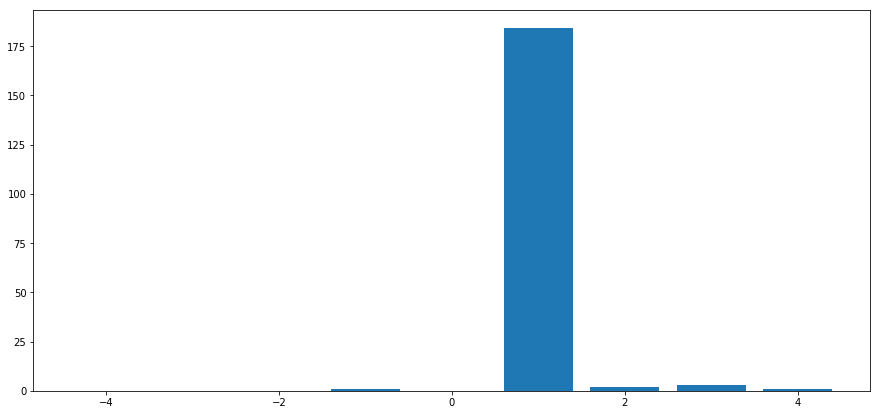

freq=[0, 0, 0, 1, 0, 184, 2, 3, 1], mean=1.047120,var=0.139141


In [53]:
plt.figure(figsize=(15,7))
freq, mean, var = result_retrive(counters, '改革', '开放')
plt.bar(range(-4,5), freq)
plt.show()
print("freq=%s, mean=%f,var=%f"%(result_retrive(counters, '改革', '开放')))

从上面结果来看，一般情况下，“开放”在“改革”的下一个位置出现，而且极少例外。

## 假设检验
### t检验
$$
t = \frac{\hat{x}-\mu}{\sqrt{\frac{s^2}{N}}} = \frac{\hat{x}-\mu}{\sqrt{\frac{\hat{x}}{N}}}~~~~~~~(课件第26页)
$$

In [72]:
def counter(data_dir):
    filenames = os.listdir(data_dir)
    bigram_counter = Counter()
    word_counter = Counter()
    for filename in filenames:
        with open(os.path.join(data_dir, filename), 'r') as F:
            for line in F.readlines():
                words = word_split(line)
                bigrams = bigram_construct(words)
                word_counter.update(words)
                bigram_counter.update(bigrams)
    return bigram_counter, word_counter

# bigram_counter, word_counter = counter(data_dir)

def t_test(bigram_counter, word_counter):
    result_list = list()
    total_word = sum(word_counter.values())
    for bigram in bigram_counter.keys():
        mu = (word_counter[bigram[0]] * word_counter[bigram[1]] * 1.0) / (total_word**2)
        t = (bigram_counter[bigram] / total_word - mu) / math.sqrt(bigram_counter[bigram] * 1.0 / total_word**2)
        result_list.append([bigram, t, bigram_counter[bigram], word_counter[bigram[0]], word_counter[bigram[1]]])
    return result_list
t_list = t_test(*counter(data_dir))
sorted(t_list, key=lambda t_item : t_item[1], reverse = True)[:10]

[[('１', '月'), 38.10007734104755, 1467, 2636, 2683],
 [('日', '电'), 29.02211005439933, 848, 2639, 995],
 [('１９９７', '年'), 25.250125493290135, 644, 674, 4386],
 [('这', '一'), 22.467510599052368, 538, 2611, 5925],
 [('两', '国'), 21.17947124555063, 451, 1603, 696],
 [('新', '的'), 20.812502868142857, 597, 1848, 43904],
 [('这', '是'), 20.303211042605685, 456, 2611, 7882],
 [('一', '种'), 20.180666050848945, 416, 5925, 680],
 [('北京', '１'), 19.833134356352723, 400, 1161, 2636],
 [('一', '年'), 19.344121327286953, 429, 5925, 4386]]

### $\chi^2$检验

$$
\chi^2 = \frac{N(O_{11}O_{22}-O_{12}O_{21})}{(O_{11}+ O_{12})(O_{11}+ O_{21})(O_{12}+ O_{22})(O_{21}+ O_{22})}
$$

In [73]:
def counter(data_dir):
    filenames = os.listdir(data_dir)
    bigram_counter = Counter()
    word_counter = Counter()
    for filename in filenames:
        with open(os.path.join(data_dir, filename), 'r') as F:
            for line in F.readlines():
                words = word_split(line)
                bigrams = bigram_construct(words)
                word_counter.update(words)
                bigram_counter.update(bigrams)
    return bigram_counter, word_counter

bigram_counter, word_counter = counter(data_dir)

def chi2_test(bigram_counter, word_counter):
    result_list = list()
    total_word = sum(word_counter.values())
    for bigram in bigram_counter.keys():
        O11 = bigram_counter[bigram]
        e1 = word_counter[bigram[0]]
        e2 = word_counter[bigram[1]]
        O12 = e1 - O11
        O21 = e2 - O11
        O22 = total_word - O11 - O12 - O21  # not truely correct
        chi = (total_word * (O11*O22 - O12*O21)**2 * 1.0) / ((O11+O12)*(O11+O21)*(O12+O22)*(O21+O22))
        result_list.append([bigram, chi, bigram_counter[bigram], word_counter[bigram[0]], word_counter[bigram[1]]])
    return result_list
chi2_list = chi2_test(*counter(data_dir))
sorted(chi2_list, key=lambda t_item : t_item[1], reverse = True)[:10]

[[('年发电量', '四十五亿'), 917024.0, 1, 1, 1],
 [('支槽', '云系'), 917024.0, 1, 1, 1],
 [('完钻', '交井'), 917024.0, 1, 1, 1],
 [('客货', '滚装'), 917024.0, 1, 1, 1],
 [('劳工', '远涉重洋'), 917024.0, 1, 1, 1],
 [('甄', '炳禧'), 917024.0, 1, 1, 1],
 [('瓦楞', '纸板箱'), 917024.0, 1, 1, 1],
 [('氧化', '物化'), 917024.0, 1, 1, 1],
 [('物化', '歧化酶'), 917024.0, 1, 1, 1],
 [('东方红牌', '履带'), 917024.0, 1, 1, 1]]

In [74]:
chi2_list_filter = [x for x in chi2_list if x[2] > 10 and x[3]>10]
sorted(chi2_list_filter, key=lambda t_item : t_item[1], reverse = True)[:10]

[[('取保', '候审'), 917023.9999999999, 17, 17, 17],
 [('尉', '健行'), 871169.9498228399, 57, 60, 57],
 [('常任', '理事国'), 840604.4166556709, 11, 12, 11],
 [('配电', '变压器'), 809137.0587946632, 15, 15, 17],
 [('薄', '一波'), 775939.9999187989, 22, 26, 22],
 [('辛', '业江'), 755193.7646681638, 14, 17, 14],
 [('迟', '浩田'), 733610.3995777444, 44, 55, 44],
 [('江', '泽民'), 714720.3789405614, 344, 435, 349],
 [('防震', '减灾'), 711278.8268901174, 11, 12, 13],
 [('童', '志成'), 667981.2929154019, 50, 66, 52]]

上面是$\chi^2$检验的结果.当bigram的两个词都是低频词的时候,$\chi^2$的值会比较大，因此，我们对结果进行了进一步筛选，得到图2的结果。图2中，可以看出，$\chi^2$的结果中已经优于t-test，但是仍然不能让人满意。

## 点对互信息
$$
I(x;y) = \log{\frac{p(x,y)}{p(x)p(y)}}
$$

In [75]:
def counter(data_dir):
    filenames = os.listdir(data_dir)
    bigram_counter = Counter()
    word_counter = Counter()
    for filename in filenames:
        with open(os.path.join(data_dir, filename), 'r') as F:
            for line in F.readlines():
                words = word_split(line)
                bigrams = bigram_construct(words)
                word_counter.update(words)
                bigram_counter.update(bigrams)
    return bigram_counter, word_counter

bigram_counter, word_counter = counter(data_dir)

def mut_info_test(bigram_counter, word_counter):
    result_list = list()
    total_word = sum(word_counter.values())
    for bigram in bigram_counter.keys():
        O11 = bigram_counter[bigram]
        e1 = word_counter[bigram[0]]
        e2 = word_counter[bigram[1]]
        mut_info = math.log2 (O11 * total_word * 1.0 / (e1 * e2))
        result_list.append([bigram, mut_info, bigram_counter[bigram], word_counter[bigram[0]], word_counter[bigram[1]]])
    return result_list
mut_info_list = mut_info_test(*counter(data_dir))
sorted(mut_info_list, key=lambda t_item : t_item[1], reverse = True)[:10]

[[('年发电量', '四十五亿'), 19.80659996641187, 1, 1, 1],
 [('支槽', '云系'), 19.80659996641187, 1, 1, 1],
 [('完钻', '交井'), 19.80659996641187, 1, 1, 1],
 [('客货', '滚装'), 19.80659996641187, 1, 1, 1],
 [('劳工', '远涉重洋'), 19.80659996641187, 1, 1, 1],
 [('甄', '炳禧'), 19.80659996641187, 1, 1, 1],
 [('瓦楞', '纸板箱'), 19.80659996641187, 1, 1, 1],
 [('氧化', '物化'), 19.80659996641187, 1, 1, 1],
 [('物化', '歧化酶'), 19.80659996641187, 1, 1, 1],
 [('东方红牌', '履带'), 19.80659996641187, 1, 1, 1]]

In [76]:
mut_info_list_filter = [x for x in mut_info_list if x[2] > 10 and x[3]>10]
sorted(mut_info_list_filter, key=lambda t_item : t_item[1], reverse = True)[:10]

[[('常任', '理事国'), 16.221637465690712, 11, 12, 11],
 [('防震', '减灾'), 15.980629366186918, 11, 12, 13],
 [('淘', '粪'), 15.873714162270407, 11, 12, 14],
 [('配电', '变压器'), 15.71913712516153, 15, 15, 17],
 [('取保', '候审'), 15.71913712516153, 17, 17, 17],
 [('辛', '业江'), 15.71913712516153, 14, 17, 14],
 [('轮值', '主席国'), 15.347168347774572, 14, 14, 22],
 [('伍', '绍祖'), 15.106160248270777, 16, 26, 16],
 [('薄', '一波'), 15.106160248270777, 22, 26, 22],
 [('防盗', '报警器'), 14.932130848495728, 15, 20, 22]]

上述结果是互信息的结果，从结果来看，互信息与$\chi^2$比较相似，低频此往往拥有较大的互信息。